In [1]:
from nimare.generate import create_coordinate_dataset
from nimare.meta.ale import ALE
from nimare.meta.mkda import KDA, MKDADensity
from nimare.meta.kernel import KDAKernel, ALEKernel, MKDAKernel
from nimare.correct import FDRCorrector, FWECorrector

import numpy as np
import pandas as pd
import seaborn as sns


ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [2]:
# create 100 datasets with random coordinates
N_DSET = 100
NOISE_FOCI = 30
noise_datasets = [create_coordinate_dataset(foci=0, n_noise_foci=NOISE_FOCI, seed=seed)[1] for seed in range(N_DSET)]

In [4]:
# set up the meta analysis estimators
metas = {'ale': ALE(ALEKernel()), 'kda': KDA(KDAKernel()), 'mkda': MKDADensity(MKDAKernel())}


In [5]:
# TODO: use multiple comparisons corrector
corr = FWECorrector(method="montecarlo", n_iters=100, n_cores=8)

In [6]:
# collect number of false positives in each analysis and keep p-value array.
meta_fpr = {'ale': [], 'kda': [], 'mkda': []}
meta_arr = {'ale': [], 'kda': [], 'mkda': []}
for meta in metas:
    for idx, dset in enumerate(noise_datasets):
        print(f"running {meta} on dset {idx}")
        res = metas[meta].fit(dset)
        p_map = res.get_map("p", return_type="array")
        fpr = (p_map < 0.05).sum() / p_map.shape[0]
        meta_fpr[meta].append(fpr)
        meta_arr[meta].append(p_map)



running ale on dset 0
running ale on dset 1
running ale on dset 2
running ale on dset 3
running ale on dset 4
running ale on dset 5
running ale on dset 6
running ale on dset 7
running ale on dset 8
running ale on dset 9
running ale on dset 10
running ale on dset 11
running ale on dset 12
running ale on dset 13
running ale on dset 14
running ale on dset 15
running ale on dset 16
running ale on dset 17
running ale on dset 18
running ale on dset 19
running ale on dset 20
running ale on dset 21
running ale on dset 22
running ale on dset 23
running ale on dset 24
running ale on dset 25
running ale on dset 26
running ale on dset 27
running ale on dset 28
running ale on dset 29
running ale on dset 30
running ale on dset 31
running ale on dset 32
running ale on dset 33
running ale on dset 34
running ale on dset 35
running ale on dset 36
running ale on dset 37
running ale on dset 38
running ale on dset 39
running ale on dset 40
running ale on dset 41
running ale on dset 42
running ale on dset 4

In [7]:
# display average false positive rate for each estimator
print({meta: np.array(fpr).mean() for meta, fpr in meta_fpr.items()})

{'ale': 0.05776417906527819, 'kda': 0.07706587350571015, 'mkda': 0.03408631096987126}


In [8]:
# check to see what the expected correlation is if both arrays have similar numbers
# int(np.array([(meta_arr[meta][idx] == meta_arr[meta][idx].max()).sum() for meta in metas for idx in range(len(noise_datasets))]).mean())


In [9]:
# correlate the p-value arrays of each meta analysis estimator with each other
# to identify the relationship between meta analysis estimators 
meta_p_correlations = np.array([
    np.corrcoef([meta_arr['ale'][idx], meta_arr['kda'][idx], meta_arr['mkda'][idx]]) for idx in range(len(meta_arr['ale']))
])

In [10]:
ale_kda_corr = meta_p_correlations[:, 0, 1]
ale_mkda_corr = meta_p_correlations[:, 0, 2]
kda_mkda_corr = meta_p_correlations[:, 1, 2]

In [11]:
df_corr = pd.DataFrame({'ale_kda': ale_kda_corr, 'ale_mkda': ale_mkda_corr, 'kda_mkda': kda_mkda_corr})
df_fpr = pd.DataFrame(meta_fpr).melt(var_name="meta_estimator", value_name="false_positive_rate")

Text(0.5, 1.0, 'False Positive Rates for Meta Analysis Estimators')

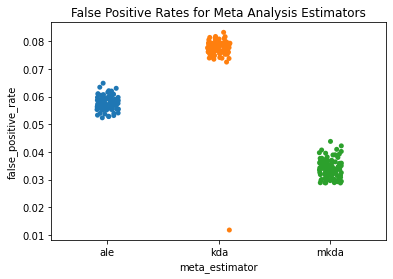

In [12]:
fig = sns.stripplot(data=df_fpr, x='meta_estimator', y='false_positive_rate')
fig.set_title("False Positive Rates for Meta Analysis Estimators")

Text(0.5, 1.0, 'Correlations of p-value arrays between Meta Analysis Estimators')

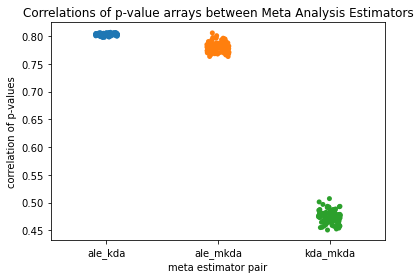

In [13]:
fig = sns.stripplot(data=df_corr)
fig.set_ylabel("correlation of p-values")
fig.set_xlabel("meta estimator pair")
fig.set_title("Correlations of p-value arrays between Meta Analysis Estimators")